# Wind field models
Let's start by importing the relevant packages.

In [27]:
# We want to work with modules from parent directory
import sys
sys.path.append('../')
# Some of the data loading functions produce warnings,
# Let's supress them for neatness sake.
import warnings
warnings.filterwarnings("ignore")
# Load windfield models
from models.random_forest import RandomForestField
from models.averaging_windfield import AveragingWindfield
from models.weighting_windfield import WeightingWindfield
from models.quadratic_fourier_windfield import FourierWindfield
from models.kriging_windfield import KrigingWindfield
from models.residual_windfield import ResidualWindfield
from models.MCMC_fourier_windfield import RandomFourierFeatures
# Load necessary help functions
from error_estimation.windfield_prediction import do_random_predictions
import framework.data_loader as dl
import numpy as np
import matplotlib.pyplot as plt

The `Windfield` class form `windfield.py` in the `framework` package provides an easily accessible framework for windfield reconstruction in python. An instance of the `Windfield` class is a model with two functions:

* `fit`, which trains the model on user-defined wind data, and
* `predict`, which uses the trained model to interpolate the wind velocities to unseen points in space.

Below we will describe some of the available windfield models and provide some examples of how to use them.

### Random forest
The `RandomForestField` windfield model from `random_forest_any_degree.py` predicts wind velocities, taking latitude and longitude (`x`, `y`) as well as altitude (`z`)into account. The required arguments for creating a random forest are

* `altitude_lookup`, a function that returns the altitude `z` for any given point (`x`, `y`) in the geographic area of interest.
* `**forest_args`, arguments put thrugh the `RandomForestRegressor` from `sklearn`. For example, writing `n_estimators = 3` will initialise a random forest with 3 trees.

There is also a voluntary parameter defaulting to 4:

* `poly_degree`, which determines a map from the triplet (`x`, `y`, `z`) to a higher dimensional space consisting of polynomial basis functions for all multivariate polynomials up to the specified degree. This space is then used as the feature space in the random forest.

The class function `make_altitude_lookup()` generates a function that returns the 1-nearest neighbor altitude approximates provided a data frame with measurements `x`, `y` and `altitude`. The function `make_random_forest_field()` lets us bypass creating a lookup by just providing such a data frame instead. 

In [8]:
# Load some data for making the lookup.
# This does not have to be all of the data, just one point for each weather station.
data = dl.load_parquet("../Data/wind_data_2018.parquet")

rf_wf = RandomForestField.make_random_forest_field(data, poly_degree = 3, n_estimators = 3)

The weighting windfield turned out to be a good way to boost existing methods. See the research file for more specifics.

### Fourier Windfield
The `FourierWindfield` model from `quadratic_fourier_windfield.py` uses a fourier series to estimate the windfield. Specifically, it minimizes a quadratic expression of the fourier coefficients. The `FourierWindfield` takes the following arguments:

* `shape`, a tuple which determines the subset of frequencies which are used for the series. For example, if `shape`= (11,7), the model uses the basis functions $\{e^{i\pi (mx+ny)}\}$ where $-5\leq m\leq 5$ and $-3 \leq n \leq 3$. Note that because of this, `shape` has to consist of odd integers.
* `reg_type`, the type of regularization used for optimization. Can be `ridge`, in which case the regularization is the $L^2$-norm, or `sobolev` in which case the sobolev-norm is used instead.
* `reg_param`, a weight adjusting the amount of regularization.
* `div_param`, a weight adjusting the divergence-penalty, which is just a $L^2$-norm regularization on the divergence of the series. If `div_param` is set to `float('inf')` the divergence-penalty is instead treated as a constraint, to yield a completely divergence-free field.


The underlying `FourierSeries` object also has a `periods` property which is an array of length 2 that determines the x and y periods of the basis terms. It is set to $[4\cdot 10^6, 4\cdot 10^6]$ by default to fit the geodata of sweden, but can be manually adjusted. Increasing the `periods` in either direction can get rid of artefacts due to the periodicity of the fourier series, however more terms might be needed to increase accuracy which in turn decreases the performance. Here's the best Fourier Windfield I have found so far:

In [4]:
f_wf = FourierWindfield(shape = (21,21), reg_type = 'sobolev', reg_param = 0.017, div_param = 0.047)

And here's how to change the periods of the basis terms if needed:

In [5]:
f_wf.series.periods = 4*1e6 * np.ones((2,1))

### Adaptive Random Fourier Features

The Random Fourier features method is based on a Fourier series, but instead of looking at a fixed grid of frequencies, the algorithm tries to sample the frequencies from an optimal distribution. The algorithm is discussed at length in the article (Kiessling et al, 2020, Wind Field Reconstruction with Adaptive Random Fourier Features). The `RandomFourierFeatures` windfield from `MCMC_fourier_windfield.py` implements this algorithm. It takes the arguments

* `n_terms`, the number of Fourier terms in the Fourier series.
* `n_steps`, the number of steps taken by the Metropolis-Hastings algorithm which samples from the optimal distribution. For 400 terms, the recommended number of steps is about 500. 
* `reg_param`, the amount of regularisation, same as the standard Fourier series.
* `div_param`, a weight adjusting the divergence penalty, same as the standard Fourier series.
* `gamma, sigma`, hyper parameters for the Metropolis-Hastings algorithm. By default both are set to 2 which yields reasonable results.

All of these values need tuning for optimal performance. To learn how this can be done, see the `TUTORIAL-Windfield_scoring.ipynb` notebook. The `fit()` function returns `coeff_history` and `weight_history` which contain the steps of the Metropolis Hastings algorithm. 


In [46]:
rf_wf = RandomFourierFeatures(n_terms = 200, n_steps = 400, reg_param = 0.1, div_param = 0.01, gamma = 1.5, sigma = 2.5)

# Extract one hour's worth of data
data_snapshot = data[data["date"] == "2018-01-01"][data["time"] == "10:00"]
coef_hist, weight_hist = rf_wf.fit(data_snapshot)

This history can then be used to study the convergence of the Metropolis Hastings algorithm. For example, we can plot the transitions between each step as `n_terms` trajectories in the frequency domain. As described in the previous section, the Fourier frequencies is a set of integer pairs $f =\{(m_k,n_k)\}_{k=1}^{K}$ where $K$ = `n_terms`. The Metropolis Hastings algorithm generates a sequence $\{f_i\}_{i=1}^{N}$ of such sets, where $N$ = `n_steps`. Note that in the following plot, the frequencies are significantly more spread out than the square grid used in the `FourierWindfield` model.

Text(0, 0.5, 'Frequency component 2')

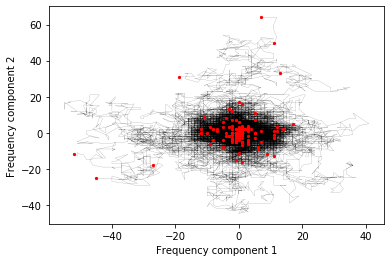

In [50]:
# Plot all trajectories
for i in range(200):
    plt.plot(weight_hist[:, i, 0], weight_hist[:, i, 1], color='black', linewidth=0.1, zorder=0)

# Scatter the last step of the algorithm
plt.scatter(weight_hist[-1, :, 0], weight_hist[-1, :, 1], s=5, c="red", zorder=1)

# Labels
plt.xlabel("Frequency component 1")
plt.ylabel("Frequency component 2")

### Kriging Windfield

Kriging seems to be the industry standard when it comes to interpolating geological data. The method works by modeling the values of some scalar field $u$ in each point $x$ as some trend $f$ plus random noise $\epsilon(x)$: $u(x) = f(x) + \epsilon(x)$. The random noise has the property of being weakly stationary and furthermore, the variance of $\epsilon(x)-\epsilon(y)$ only depends on the distance $|x-y|$ between $x$ and $y$. Meaning, $\mathrm{Var}\left[\epsilon(x) -\epsilon(y)\right] = \gamma(|x-y|)$ where $\gamma$ is called the `variogram`. Given this model, it is possible to derive the statistically optimal predictions with respect to the mean square error. `KrigingWindfield` from `kriging_windfield.py` does precisely this. The keyword argument `**ukrige_args` is fed through the `UniversalKriging` object from the `pykrige` package by Benjamin S. Murphy. Examples of allowed keyword arguments are:

* `variogram_model`, the variogram model to use, specified as a string. Examples of allowed models are "linear", "gaussian", "spherical" and "exponential". 
* `nlags`, a parameter which adjusts how the variogram function is fitted to the data. It is very unlikely that even two pairs of data points end up the same distance from eachother, so the algorithm creates a histogram with `nlags` bins for the values $|x_i-x_j|, i,j = 1,\dots,n$.

Note that the parameters `x`,`y` and `z` must not be specified by the user since they are defined during training.
Here's and example how to instantiate the `KrigingWindfield` class:

In [16]:
krg_wf = KrigingWindfield(variogram_model = "linear", nlags = 10)

### Neural Network Windfield
The `MLPWindfield` class from `mlp_windfield.py` implements a multilayer perceptron (A type of feedforward neural network) to predict wind velocities.  For a complete guide to the Neural network windfield, see the separate notebook `neural_network_demo_tronstad.ipynb` on the topic by Magnus Tronstad. 

# Ensemble Windfields

In addition to the previously mentioned windfield models, there are also a couple of ensemble models available. Currently, we have `ResidualWindfield` and `WeightingWindfield`. 

### Residual Windfield

The `ResidualWindfield` model from `residual_windfield.py` recursively fits a sequence of windfields to the residuals of the earlier windfield predictions. It takes one argument:

* `windfields`, a list of `WindField` objects to use. Call the entries `windfields` $w_i, \quad i= 1,\dots,N$. Then, $w_n$ is fitted to the residuals $u_j - \sum_{i=1}^{n-1}w_i(x_j)$ and the final prediction of the velocity at some point $x$ is given by $\sum_{i=1}^N w_i(x)$. 


For example, let's krige the residuals of the fourier windfield in order to get better results. 

In [12]:
# Load data
data = dl.load_parquet("../Data/wind_data_2018.parquet")

# Create windfield
res_wf = ResidualWindfield([f_wf, krg_wf])

# Make some predictions
pred = do_random_predictions(f_wf, data, n_splits = 5, n_samples = 100, seed = 100)

Predicting time: 2018-01-30 21:00:00
Predicting time: 2018-11-01 17:00:00
Predicting time: 2018-10-28 19:00:00
Predicting time: 2018-02-24 23:00:00
Predicting time: 2018-09-05 05:00:00
Predicting time: 2018-07-30 00:00:00
Predicting time: 2018-10-10 03:00:00
Predicting time: 2018-12-12 16:00:00
Predicting time: 2018-12-28 15:00:00
Predicting time: 2018-04-19 08:00:00
Predicting time: 2018-01-09 22:00:00
Predicting time: 2018-09-21 12:00:00
Predicting time: 2018-10-29 16:00:00
Predicting time: 2018-05-16 01:00:00
Predicting time: 2018-06-07 12:00:00
Predicting time: 2018-03-22 19:00:00
Predicting time: 2018-07-17 11:00:00
Predicting time: 2018-04-16 13:00:00
Predicting time: 2018-06-25 01:00:00
Predicting time: 2018-03-22 03:00:00
Predicting time: 2018-02-28 02:00:00
Predicting time: 2018-01-26 19:00:00
Predicting time: 2018-03-08 23:00:00
Predicting time: 2018-07-27 16:00:00
Predicting time: 2018-08-16 13:00:00
Predicting time: 2018-09-19 17:00:00
Predicting time: 2018-03-28 14:00:00
P

### Weighting wind field
The `WeightingWindField` model from `weighting_windfield.py` predicts wind data using a linear combination of preexisting windfield models. The inputs are

* `windfields`, a python list of `Windfield` objects.
* `weights`, an array of weights corresponding to each of the windfields.

There is also a method `get_weights()` that given a list of predictions returns the optimal weights (in the mean square sense) for the models that generated those predictions. The predictions can be generated with `do_random_predictions()`. Using this wind field one can combine any choice of other windfields, say for example the averaging model and random forest. First, generate predictions using the windfields of choice:

In [13]:
# Fix seed for the predictions
seed = 100

# Create an averaging windfield
av_wf = AveragingWindfield()

# Generate data for the two models
pr_av = do_random_predictions(av_wf, data, n_splits = 5, n_samples = 100, seed = seed)
pr_rf = do_random_predictions(rf_wf, data, n_splits = 5, n_samples = 100, seed = seed)

Predicting time: 2018-01-30 21:00:00
Predicting time: 2018-11-01 17:00:00
Predicting time: 2018-10-28 19:00:00
Predicting time: 2018-02-24 23:00:00
Predicting time: 2018-09-05 05:00:00
Predicting time: 2018-07-30 00:00:00
Predicting time: 2018-10-10 03:00:00
Predicting time: 2018-12-12 16:00:00
Predicting time: 2018-12-28 15:00:00
Predicting time: 2018-04-19 08:00:00
Predicting time: 2018-01-09 22:00:00
Predicting time: 2018-09-21 12:00:00
Predicting time: 2018-10-29 16:00:00
Predicting time: 2018-05-16 01:00:00
Predicting time: 2018-06-07 12:00:00
Predicting time: 2018-03-22 19:00:00
Predicting time: 2018-07-17 11:00:00
Predicting time: 2018-04-16 13:00:00
Predicting time: 2018-06-25 01:00:00
Predicting time: 2018-03-22 03:00:00
Predicting time: 2018-02-28 02:00:00
Predicting time: 2018-01-26 19:00:00
Predicting time: 2018-03-08 23:00:00
Predicting time: 2018-07-27 16:00:00
Predicting time: 2018-08-16 13:00:00
Predicting time: 2018-09-19 17:00:00
Predicting time: 2018-03-28 14:00:00
P

Then, use the data to estimate the optimal weights for the two models using `get_weights()` and use them to create a new windfield.

In [14]:
# Get weights
weights = WeightingWindfield.get_weights([pr_av, pr_rf])

# Create windfield
w_wf = WeightingWindfield([av_wf, rf_wf], weights)

print("Optimal weights: {0:.2f} averaging + {1:.2f} random forest".format(weights[0], weights[1]))

Optimal weights: 0.79 averaging + 0.23 random forest
